In [31]:
import json
from pprint import pprint
from termcolor import colored
from colored import fg, bg, attr
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# if using a Jupyter notebook, includue:
%matplotlib inline
data_file = "../predictor_only_enitites.jsonl"
id2name = "../data/id2name.json"

NUMBER_OF_SAMPELS = 100

color = bg('yellow_1') + fg('black')
reset = attr('reset')
blue = "blue"
green = "green"

print()

with open(id2name, 'r') as fp:
    id2name = json.load(fp)

def in_pos(indx, positions):
    for ent_pos in positions:
        if ent_pos[0] <= indx < ent_pos[1]:
            return True

    return False

In [32]:
def change_word_by_entity(entity_str, this_sentence,i,color):
        if list(map(lambda x: x.lower(), this_sentence[i:i + len(entity_str.split(" "))])) == entity_str.split():
            this_sentence = this_sentence[:i] + [colored(w, color, attrs=['bold']) for w in entity_str.split()] + \
                            this_sentence[i + len(entity_str.split(" ")):]
        return this_sentence


In [33]:
preffix = ""
def _show_sentence(head,tail,this_sentence,relation,correct_relation = None, is_prediction = False,prob : str = "",score: str = ""):
#     print(preffix + "head:", colored(head, 'blue', attrs=['bold']), "  ,  ", "tail", colored(tail, 'green', attrs=['bold']))          
    this_sentence = this_sentence.split()
    for i, word in enumerate(this_sentence):
            if word.lower() == head.split()[0]:
                this_sentence = change_word_by_entity(head, this_sentence,i,blue)
            if word.lower() == tail.split()[0]:
                this_sentence = change_word_by_entity(tail, this_sentence,i,green)
    color = 'yellow' if correct_relation is None or relation == correct_relation else 'grey'
    if is_prediction: color = "red"
    if len(prob) > 0:
        print(preffix + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence) +" " + colored(prob, "magenta",attrs=['bold'])+"; "+ 
              colored(score, "magenta",attrs=['bold']))
    else:
        print(preffix + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence))

In [34]:
def show_set(data):
    correct_relation = data['correct_relation']
    prediction = data["prediction"]
    query = data['query']
    head = data['query_head']
    tail = data['query_tail']
    probability = data['probability'].replace("'","")[1:-1].split(",")
    scores = data['scores']
    _show_sentence(head,tail,query,correct_relation)
    print()

    for k in range(5):
        this_sentence = data["sentence_" +str(k)]
        head = data['sentence_'+str(k)+'_head']
        tail = data['sentence_'+str(k)+'_tail']
        relation = data['sentence_'+str(k)+'_relation']
        _show_sentence(head,tail,this_sentence,relation,correct_relation,  k == int(prediction),probability[k],
                       "{:.2f}".format(scores[k]))
    print()
    return correct_relation
        

In [35]:
total_wrong = 0
total_correct = 0
result_per_type = {}
correct_scroes = []
wrong_scores = []
wrong_prediction_which_rel = {}
with open(data_file) as f:
    for ex_index,line in enumerate(f,1):
        data = json.loads(line)
        scores = data['scores']
        pred_rel = data['sentence_' + data["prediction"] +'_relation']
        pred_score = scores[int(data["prediction"])]
        the_gold_rel = data['correct_relation']
        if data['answer'] == "wrong":
            total_wrong +=1
            if pred_score > 60:
                print("wrong example number: ",total_wrong,  "example number: ", ex_index)
                show_set(data)
                print()
            wrong_prediction_which_rel[the_gold_rel] = wrong_prediction_which_rel.get(the_gold_rel,Counter())
            wrong_prediction_which_rel[the_gold_rel].update([pred_rel])
            wrong_scores.append(pred_score)
            result_per_type[the_gold_rel] = result_per_type.get(the_gold_rel,[[],[]])
            result_per_type[the_gold_rel][0].append(data)
            
            
        else:
            result_per_type[the_gold_rel] = result_per_type.get(the_gold_rel,[[],[]])
            result_per_type[the_gold_rel][1].append(data)
            correct_scroes.append(pred_score)
            total_correct +=1





wrong example number:  340 example number:  1497
main subject	 In 1887 Zamenhof finalized his tinkering with the publication of the " unua libro " ( " First Book " ) , which contained the esperanto language as we know it today .

original language of film or TV show	 A malayalam language film , achanurangatha veedu , was made by director Lal Jose based on this case . 1.00; 61.35
main subject	 In 1991 , while Fishman was still incarcerated , " Time " magazine published a highly critical cover story on scientology by Richard Behar .  0.00; 33.31
located in or next to body of water	 It is situated on the right bank of the danube , 16 km south of deggendorf .  0.00; 28.97
voice type	 nick afoa ( born 1986 in Auckland ) is a New Zealand tenor and former New Zealand age grade rugby player of Samoan and Croatian heritage .  0.00; 28.53
position played on team / speciality	 Combo guards became prominent in the 1990s , when players such as allen iverson and Penny Hardaway were switched between 

In [36]:
print(total_wrong/(total_correct+total_wrong))
print((total_correct+total_wrong))

0.2138
10000


In [37]:
for k,v in result_per_type.items():
    print("acc for ", k)
#     print("total from this category:",(len(v[0])+len(v[1])))
    print(len(v[1])/ (len(v[0])+len(v[1]) ))

acc for  member of
0.48534201954397393
acc for  crosses
0.9668674698795181
acc for  part of
0.41050903119868637
acc for  mother
0.6572379367720466
acc for  child
0.655448717948718
acc for  main subject
0.5924657534246576
acc for  military rank
0.9670846394984326
acc for  located in or next to body of water
0.797583081570997
acc for  voice type
1.0
acc for  follows
0.75625
acc for  original language of film or TV show
0.9336650082918739
acc for  position played on team / speciality
0.9626016260162602
acc for  spouse
0.7122641509433962
acc for  competition class
0.9730134932533733
acc for  constellation
0.8153364632237872
acc for  sport
0.8473413379073756


In [38]:
# check similarity between relations on train and dev
wrong_scores = np.array(wrong_scores)
correct_scroes = np.array(correct_scroes)


In [39]:
wrong_scores.mean()


37.723232936591494

In [40]:
correct_scroes.mean()


42.823280920602684

In [41]:
wrong_scores.std()


3.2567313720316005

In [42]:
correct_scroes.std()


4.907898756197537

In [43]:
np.max(wrong_scores)


61.34579086303711

(array([ 40., 369., 784., 697., 202.,  41.,   3.,   0.,   1.,   1.]),
 array([28.21909904, 31.53176823, 34.84443741, 38.15710659, 41.46977577,
        44.78244495, 48.09511414, 51.40778332, 54.7204525 , 58.03312168,
        61.34579086]),
 <a list of 10 Patch objects>)

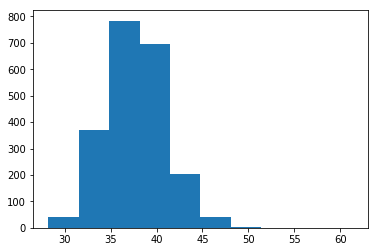

In [44]:
plt.hist(wrong_scores)



(array([0.00175097, 0.01659774, 0.05147125, 0.07368669, 0.07857482,
        0.04081951, 0.01747323, 0.00339251, 0.00280885, 0.00021887]),
 array([28.74953842, 32.23635635, 35.72317429, 39.20999222, 42.69681015,
        46.18362808, 49.67044601, 53.15726395, 56.64408188, 60.13089981,
        63.61771774]),
 <a list of 10 Patch objects>)

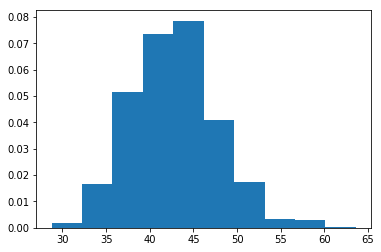

In [45]:
plt.hist(correct_scroes,density=True)

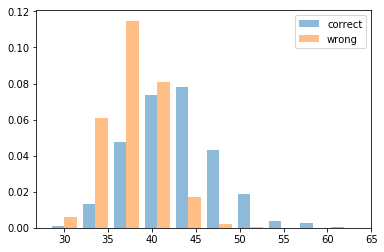

In [46]:
bins = [35,45,55,60,65,70]
plt.hist([correct_scroes,wrong_scores], 10, alpha=0.5, label=['correct','wrong'],density=True)
# plt.hist(wrong_scores, 10, alpha=0.5, label='wrong')
plt.legend(loc='upper right')
# plt.show()

In [18]:
# check unigrams intersection with other relations, both on tokens and entities
# on train as well
for d in result_per_type['voice type'][0]:
    show_set(d)
    print()
    

voice type	 elaine bonazzi ( born 1936 , Endicott , New York ) is an American operatic mezzo - soprano who had an active international career from the 1950s through the 1990s .

military rank	 rear admiral james thomas smith ( November 1 , 1908-June 28 , 1990 ) was an officer of the United States Navy during World War II . 0.11; 38.23
voice type	 nicola monti ( November 21 , 1920 – March 1 , 1993 ) was an Italian opera singer , one of the leading tenori di grazia of the 1950s .  0.12; 38.37
competition class	 lorenzo parra ( born August 19 , 1978 ) is a Venezuelan professional boxer who held the WBA flyweight title from 2003 to 2007 .  0.77; 40.22
follows	 After waiting almost two years to release " 100 wayz " through Koch Records , Tha Dogg Pound left Koch and began working on " That Was Then , This Is Now . "  0.00; 30.48
constellation	 ngc 4088 and NGC 4085 are members of the M109 Group , a group of galaxies located in the constellation ursa major .  0.00; 32.26




In [19]:
def show_statson_all_relation(correct = 0):
    pred_acc = []
    scores_result = []
    std_result = [] 
    for k,v in result_per_type.items():
        scores_category = np.array(list(map(lambda x: x['scores'][int(x['prediction'])],v[correct])))
        pred_acc.append(len(v[1])/(len(v[0])+len(v[1]))*100)
        scores_result.append(scores_category.mean())
        std_result.append(scores_category.std())
        print(f"{k}:\t {scores_category.mean():.2f} +- {scores_category.std():.2f} ; {len(v[1])/(len(v[0])+len(v[1]))*100:.2f}%")
    #     print( k ,scores_category.mean(), "+-",scores_category.std(), " Acc is:", len(v[1])/(len(v[0])+len(v[1])))
    pred_acc = np.array(pred_acc)
    scores_result = np.array(scores_result)
    std_result = np.array(std_result)
#     X = np.stack((pred_acc,scores_result),axis=0)
#     print(np.cov(X))
#     print(np.corrcoef(np.stack((pred_acc,scores_result),axis=0)))
    return pred_acc,scores_result,std_result

In [20]:
pred_acc,scores_result_correct,std_result_correct = show_statson_all_relation(1)

member of:	 36.14 +- 1.68 ; 55.37%
crosses:	 43.08 +- 3.11 ; 96.39%
part of:	 36.14 +- 2.77 ; 38.42%
mother:	 37.05 +- 1.69 ; 58.07%
child:	 37.46 +- 1.94 ; 64.90%
main subject:	 37.41 +- 3.38 ; 59.93%
military rank:	 43.63 +- 2.77 ; 97.18%
located in or next to body of water:	 39.48 +- 2.33 ; 83.53%
voice type:	 46.39 +- 2.53 ; 99.84%
follows:	 37.93 +- 2.86 ; 67.66%
original language of film or TV show:	 38.52 +- 2.52 ; 93.70%
position played on team / speciality:	 43.10 +- 1.85 ; 94.31%
spouse:	 37.41 +- 1.84 ; 66.51%
competition class:	 47.32 +- 3.38 ; 97.15%
constellation:	 38.43 +- 2.10 ; 81.38%
sport:	 40.17 +- 2.70 ; 83.70%


In [21]:
from scipy.stats import pearsonr

In [22]:
pearsonr(pred_acc,scores_result_correct)

(0.8401013488677861, 4.643738699879324e-05)

In [23]:
pred_acc,scores_result_wrong,std_result_wrong = show_statson_all_relation(0)

member of:	 35.37 +- 1.41 ; 55.37%
crosses:	 37.63 +- 2.05 ; 96.39%
part of:	 35.69 +- 1.92 ; 38.42%
mother:	 36.85 +- 1.73 ; 58.07%
child:	 36.86 +- 1.97 ; 64.90%
main subject:	 35.58 +- 1.99 ; 59.93%
military rank:	 38.63 +- 2.37 ; 97.18%
located in or next to body of water:	 39.24 +- 2.85 ; 83.53%
voice type:	 40.22 +- 0.00 ; 99.84%
follows:	 35.69 +- 1.30 ; 67.66%
original language of film or TV show:	 36.24 +- 1.75 ; 93.70%
position played on team / speciality:	 39.77 +- 1.57 ; 94.31%
spouse:	 37.04 +- 1.98 ; 66.51%
competition class:	 37.86 +- 1.91 ; 97.15%
constellation:	 36.41 +- 1.43 ; 81.38%
sport:	 38.39 +- 2.32 ; 83.70%


In [24]:
pearsonr(pred_acc,scores_result_wrong)

(0.7225703289880748, 0.0015676944995754484)

In [25]:
scores_result_correct - scores_result_wrong

array([0.7678779 , 5.45754876, 0.4588019 , 0.20565624, 0.59657201,
       1.82349931, 5.00169318, 0.23537707, 6.17134615, 2.23889973,
       2.28013809, 3.33642598, 0.36385862, 9.45989966, 2.01646761,
       1.7853166 ])

In [26]:
print(pred_acc)

[55.37459283 96.38554217 38.42364532 58.06988353 64.90384615 59.93150685
 97.17868339 83.5347432  99.8389694  67.65625    93.69817579 94.30894309
 66.50943396 97.15142429 81.3771518  83.70497427]


In [30]:
for v in result_per_type["part of"][1]:
    show_set(v)
    print()

part of	 Moffat also brought back the character of River Song from his fourth series episodes " Silence in the Library " and " forest of the dead " .

part of	 Ulcerative colitis and familial adenomatous polyposis are the two main health conditions that lead to removal of the entire colon ( large intestine ) and rectum , which leads to the need for an ileostomy . 0.74; 35.99
child	 In the mythological tradition , hermaphroditus was a beautiful youth who was the son of Hermes ( Roman Mercury ) and aphrodite ( Venus).Ovid , " Metamorphoses " 4.287–88 .  0.08; 33.73
constellation	 NGC 1169 ( ugc 2503 ) is an intermediate barred spiral galaxy in the constellation of perseus .  0.10; 33.96
crosses	 Following a more circuitous route through Farmville in response to financial incentives from the community , the railroad constructed the famous 21 span high bridge across the appomattox river valley about east of Farmville .  0.08; 33.80
mother	 He was the son of Herod the Great and malthace the

voice type	 In 1953 , at the age of seven , Nielsen met the Austrian soprano hilde güden while she was on tour in Iowa .  0.00; 28.37
part of	 " The Seemingly Never - Ending Story " is the 13th episode of " The Simpsons " ' 17th season .  0.99; 38.82
constellation	 ngc 447 is a spiral galaxy of type ( R)SB(rs)0/a located in the constellation pisces .  0.01; 33.58


part of	 ' sad angel ' is a song by Fleetwood Mac , written by guitarist and vocalist Lindsey Buckingham , from their EP extended play , released in 2013 .

part of	 On September 17 , 2013 , he released the first single from his second studio album " my own lane " , entitled " show me " featuring Chris Brown and produced by DJ Mustard . 0.88; 34.93
follows	 The mitsubishi toppo is a light recreational vehicle ( RV ) produced by Mitsubishi Motors from 1990 until 2004 , derived from their minica kei car .  0.05; 32.15
spouse	 After his coronation , ivan asen ii arranged a wedding with anna maria , daughter of the Hungarian kin

In [414]:
for k,v in wrong_prediction_which_rel.items():
    print (k)
    print(v.most_common())
    print()

crosses
[('located in or next to body of water', 23), ('part of', 2), ('constellation', 1)]

main subject
[('follows', 23), ('part of', 22), ('sport', 21), ('member of', 16), ('constellation', 12), ('original language of film or TV show', 6), ('voice type', 6), ('military rank', 5), ('located in or next to body of water', 5), ('spouse', 5), ('mother', 4), ('crosses', 4), ('competition class', 3), ('child', 2), ('position played on team / speciality', 1)]

part of
[('constellation', 68), ('located in or next to body of water', 55), ('main subject', 46), ('crosses', 43), ('follows', 33), ('member of', 31), ('sport', 14), ('competition class', 9), ('position played on team / speciality', 8), ('voice type', 7), ('original language of film or TV show', 6), ('military rank', 6), ('mother', 3), ('child', 3), ('spouse', 1)]

member of
[('part of', 27), ('voice type', 24), ('constellation', 22), ('military rank', 22), ('competition class', 14), ('main subject', 12), ('sport', 12), ('position pl

In [ ]:
# check agremment with the model prediction 
# try to come up with b=new baselines to show that data is no good
# Elmo should do worse?
# only entity type is helpful?